In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class Unet_block(nn.Module):
    def __init__(self, out_channels):
        super(Unet_block, self).__init__()
        self.out_channels = out_channels
        self.net = nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size = 3, padding = 1),
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size = 3, padding = 1),
        nn.LazyBatchNorm2d(), nn.ReLU(),
    )
    
    def forward(self, X):
        return self.net(X)

In [ ]:
class Unet(nn.Module):
    def __init__(self, out_channels, lr = 0.1, num_classes = 21):
        super(Unet, self).__init__()
        self.out_channels = out_channels # [64, 128, 256, 512, 1024, 512, 256, 128, 64, 21]
        self.lr = lr
        self.num_classes = num_classes
        self.final_conv = nn.LazyConv2d(out_channels[-1], kernel_size = 1)
        for i in range(1, len(out_channels)//2):
            setattr(self, f'contract_{i}', Unet_block(out_channels[i-1]))
            # setattr(self, f'maxpool_{i}', nn.MaxPool2d(kernel_size = 2, stride = 2))
            # setattr(self, f'up_conv_{i}', nn.LazyConvTranspose2d(out_channels[len(out_channels)//2 -1 + i], kernel_size = 4, padding = 1, stride = 2))
            setattr(self, f'expan_{i}', Unet_block(out_channels[len(out_channels)//2 -1 + i]))
        setattr(self, f'contract_{len(out_channels)//2}', Unet_block(out_channels[len(out_channels)//2 - 1]))
   
    def forward(self, X):
        cp = []
        for i in range(len(self.out_channels)//2):
            X = getattr(self, f'contract_{i+1}')(X)
            if i != (len(self.out_channels)//2-1):
                cp.append(X)
                # X = getattr(self, f'maxpool_{i+1}')(X)
                X = F.max_pool2d(X, kernel_size = 2, stride = 2)
        
        for i in range(1, len(self.out_channels)//2):
            # X = getattr(self, f'up_conv_{i}')(X)
            X = F.upsample(X, scale_factor = 2, mode = 'bilinear', align_corners = True )
            X = F.relu(X)
            # X_ = transforms.functional.center_crop(cp[-i], X.shape[-2:])
            X = torch.cat((X,cp[-i]), dim = 1)
            X = getattr(self, f'expan_{i}')(X)
            
        X = self.final_conv(X)
        return X


In [ ]:
# out_channels = [64, 128, 256, 512, 1024, 512, 256, 128, 64, 21]
out_channels = [64, 128, 256, 512, 256, 128, 64, 21]
# out_channels = [64, 128, 256, 128, 64, 21]

In [ ]:
net = Unet(out_channels = out_channels)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary
# summary(net, input_size = [1, 3, 512, 672])
# summary(net, input_size = [1, 3, 412, 572])
# summary(net, input_size = [1, 3, 572, 572])
summary(net, input_size = [1, 3, 320, 480])

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [1, 21, 320, 480]         --
├─Unet_block: 1-1                        [1, 64, 320, 480]         --
│    └─Sequential: 2-1                   [1, 64, 320, 480]         --
│    │    └─Conv2d: 3-1                  [1, 64, 320, 480]         1,792
│    │    └─BatchNorm2d: 3-2             [1, 64, 320, 480]         128
│    │    └─ReLU: 3-3                    [1, 64, 320, 480]         --
│    │    └─Conv2d: 3-4                  [1, 64, 320, 480]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 320, 480]         128
│    │    └─ReLU: 3-6                    [1, 64, 320, 480]         --
├─Unet_block: 1-2                        [1, 128, 160, 240]        --
│    └─Sequential: 2-2                   [1, 128, 160, 240]        --
│    │    └─Conv2d: 3-7                  [1, 128, 160, 240]        73,856
│    │    └─BatchNorm2d: 3-8             [1, 128, 160, 240]        256
│

In [ ]:
L = [*net.children()]

In [ ]:
# for i in range(1, len(out_channels)//2):
#      W = bilinear_kernel(out_channels[len(out_channels)//2 -2 + i], out_channels[len(out_channels)//2 -1 + i], kernel_size = 4)
      #print(W.shape)
#      getattr(net, f'up_conv_{i}').weight.data.copy_(W)
#      print(out_channels[len(out_channels)//2 -2 + i], out_channels[len(out_channels)//2 -1 + i])
for layer in L:
     if type(layer) == nn.Conv2d or type(layer) == nn.ConvTranspose2d:
        nn.init.xavier_uniform_(layer.weight);

## VOC dataset


In [ ]:
from pytorchcv import *

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
def download_data(src, data_dir = None):
    if data_dir:
        od.download(src, data_dir = data_dir)
    else:
        od.download(src)

In [ ]:
PASCAL_VOC_2012 = 'https://www.kaggle.com/datasets/huanghanchina/pascal-voc-2012'

In [ ]:
download_data(PASCAL_VOC_2012)

100%|██████████| 3.63G/3.63G [00:47<00:00, 82.4MB/s]


In [ ]:
VOC_DIR = '/content/pascal-voc-2012/voc2012/VOC2012'

In [ ]:
crop_size = (320, 480)
# crop_size = (324, 484)
# pad = [94, 94, 94, 94]
# crop_size = (388, 388)
# pad = [92, 92, 92, 92]
# pad = [44, 44, 44, 44]
voc_train = VOCSegDataset(True, crop_size, VOC_DIR)
# voc_test = VOCSegDataset(False, crop_size, pad, VOC_DIR)

read 1114 examples


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_set, val_set = torch.utils.data.random_split(voc_train, [1000, 114])

In [ ]:
batch_size = 4
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True, 
                                         drop_last = True,
                                         pin_memory = True)
test_iter = torch.utils.data.DataLoader(val_set, batch_size, shuffle = False,
                                        drop_last = True,
                                        pin_memory = True)

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred*target).sum(dim = 2).sum(dim = 2)

    loss = (1 - ((2.*intersection + smooth) / (pred.sum(dim = 2).sum(dim = 2) + target.sum(dim = 2).sum(dim = 2) + smooth)))
    return loss.mean()

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight = 0.55):
        super(DiceBCELoss, self).__init__()
        self.dice_weight = dice_weight

    def forward(self, preds, labels, smooth = 1):
        batch_size, num_classes = preds.shape[0], preds.shape[1]
        # one_hot
        labels = F.one_hot(labels, num_classes).permute(0, 3, 1, 2).float()

        # bce
        bce = F.binary_cross_entropy_with_logits(preds, labels)

        # dice
        preds = F.sigmoid(preds)
        dice = dice_loss(preds, labels)
        
        return bce*(1-self.dice_weight) + dice*self.dice_weight

In [ ]:
def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count,epoch_samples = 0,0,0,0
    for features,labels in dataloader:
        optimizer.zero_grad()
        lbls = labels.to(default_device)
        out = net(features.to(default_device))
        loss = loss_fn(out,lbls) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        predicted = out.argmax(dim = 1)
        acc+=(predicted==lbls).sum()
        count+=labels.numel()
        epoch_samples += features.shape[0]
    return total_loss.item()/epoch_samples, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,epoch_samples,acc,loss = 0,0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out,lbls) 
            pred = out.argmax(dim = 1)
            acc += (pred==lbls).sum()
            count += labels.numel()
            epoch_samples += features.shape[0]
    return loss.item()/epoch_samples, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [ ]:
loss_fn = DiceBCELoss()
# loss_fn = calc_loss
# num_epochs, lr, wd = 5, 0.01, 1e-3
# trainer = torch.optim.SGD(net.parameters(), lr = lr, weight_decay = wd, momentum = 0.99, nesterov = True)
num_epochs, lr = 5, 0.01
trainer = torch.optim.SGD(net.parameters(), momentum = 0.9, lr = lr)
hist = train(net, train_iter, test_iter, trainer, lr, num_epochs, loss_fn)

Epoch  0, Train acc=0.727, Val acc=0.755, Train loss=0.088, Val loss=0.087
Epoch  1, Train acc=0.728, Val acc=0.755, Train loss=0.088, Val loss=0.087
Epoch  2, Train acc=0.728, Val acc=0.755, Train loss=0.088, Val loss=0.087
Epoch  3, Train acc=0.728, Val acc=0.756, Train loss=0.088, Val loss=0.087
Epoch  4, Train acc=0.730, Val acc=0.755, Train loss=0.088, Val loss=0.087


In [ ]:
def predict(img):
    X = voc_train.normalize_image(img).unsqueeze(0)
    pred = net(X.to(device)).argmax(dim = 1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [ ]:
def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device = device)
    X = pred.long()
    return colormap[X, :]

In [ ]:
test_images, test_labels = read_voc_images(VOC_DIR, True)

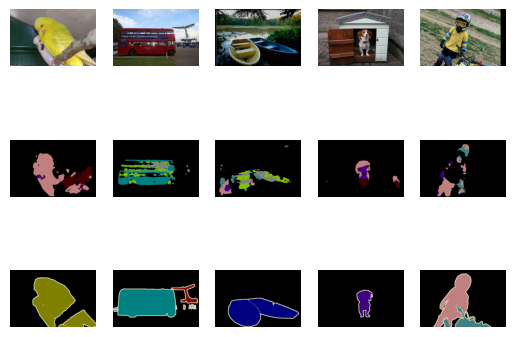

In [ ]:
n, imgs = 5, []
for i in range(20, 20+n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
            torchvision.transforms.functional.crop(
            test_labels[i], *crop_rect).permute(1,2,0)]
imgs = imgs[::3] + imgs[1::3] + imgs[2::3]

fig, ax = plt.subplots(3, n)
ax = ax.flatten()
for i in range(len(ax)):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')